# Performance Analysis with Alphalens

## Imports & Settings

In [1]:
from pathlib import Path
from collections import defaultdict
from time import time
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.performance import mean_return_by_quantile
from alphalens.plotting import plot_quantile_returns_bar
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return

In [2]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')
np.random.seed(42)
idx = pd.IndexSlice

## Alphalens Analysis

### Load predictions

In [3]:
DATA_STORE = Path('data.h5')

In [5]:
predictions = pd.read_hdf('predictions.h5', 'predictions').y_pred

In [6]:
factor = (predictions
          .unstack('ticker')
          .stack()
          .tz_localize('UTC', level='date')
          .sort_index())
tickers = factor.index.get_level_values('ticker').unique()

### Get trade prices

In [4]:
def get_trade_prices(tickers):
    prices = pd.read_hdf(DATA_STORE, 'stocks/prices/adjusted')
    prices.index.names = ['ticker', 'date']
    prices = prices.loc[idx[tickers, '2014':'2020'], 'open']
    return (prices
            .unstack('ticker')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [7]:
trade_prices = get_trade_prices(tickers)

In [8]:
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1510 entries, 2014-01-02 to 2019-12-31
Columns: 3656 entries, A to ZYME
dtypes: float64(3656)
memory usage: 42.1 MB


### Generate tearsheet input

In [11]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(5, 10, 21)).sort_index()
factor_data.info()

Dropped 6.6% entries from factor data: 6.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 772656 entries, (2015-01-09 00:00:00+00:00, A) to (2019-11-22 00:00:00+00:00, ZYME)
Data columns (total 5 columns):
5D                 772656 non-null float64
10D                772656 non-null float64
21D                772656 non-null float64
factor             772656 non-null float32
factor_quantile    772656 non-null int64
dtypes: float32(1), float64(3), int64(1)
memory usage: 29.5+ MB


### Create Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-8.843553,0.067337,-1.076574,0.865976,154628,20.012528
2,-2.048476,0.346327,-0.341201,0.329194,154487,19.994279
3,-0.846846,0.781262,0.030596,0.209524,154477,19.992985
4,-0.338665,1.553346,0.353398,0.273874,154488,19.994409
5,-0.038132,4.337543,0.837777,0.538245,154576,20.005798


Returns Analysis


,5D,10D,21D
Ann. alpha,0.028,0.027,0.032
beta,-0.056,-0.049,-0.046
Mean Period Wise Return Top Quantile (bps),4.235,3.316,3.787
Mean Period Wise Return Bottom Quantile (bps),-6.643,-6.940,-7.512
Mean Period Wise Spread (bps),10.878,10.311,11.367


Information Analysis


,5D,10D,21D
IC Mean,0.016,0.020,0.026
IC Std.,0.084,0.086,0.080
Risk-Adjusted IC,0.192,0.236,0.331
t-stat(IC),3.020,3.704,5.206
p-value(IC),0.003,0.000,0.000
IC Skew,0.004,0.215,0.213
IC Kurtosis,0.180,0.004,0.271


Turnover Analysis


,10D,21D,5D
Quantile 1 Mean Turnover,0.323,NaN,0.270
Quantile 2 Mean Turnover,0.575,NaN,0.511
Quantile 3 Mean Turnover,0.624,NaN,0.562
Quantile 4 Mean Turnover,0.588,NaN,0.524
Quantile 5 Mean Turnover,0.355,NaN,0.289


,5D,10D,21D
Mean Factor Rank Autocorrelation,0.829,0.76,NaN


<Figure size 432x288 with 0 Axes>

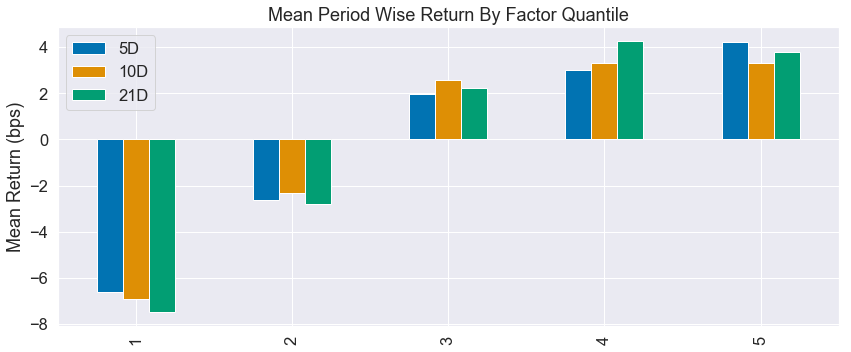

In [12]:
create_summary_tear_sheet(factor_data)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-8.843553,0.067337,-1.076574,0.865976,154628,20.012528
2,-2.048476,0.346327,-0.341201,0.329194,154487,19.994279
3,-0.846846,0.781262,0.030596,0.209524,154477,19.992985
4,-0.338665,1.553346,0.353398,0.273874,154488,19.994409
5,-0.038132,4.337543,0.837777,0.538245,154576,20.005798


Returns Analysis


,5D,10D,21D
Ann. alpha,0.028,0.027,0.032
beta,-0.056,-0.049,-0.046
Mean Period Wise Return Top Quantile (bps),4.235,3.316,3.787
Mean Period Wise Return Bottom Quantile (bps),-6.643,-6.940,-7.512
Mean Period Wise Spread (bps),10.878,10.311,11.367


<Figure size 432x288 with 0 Axes>

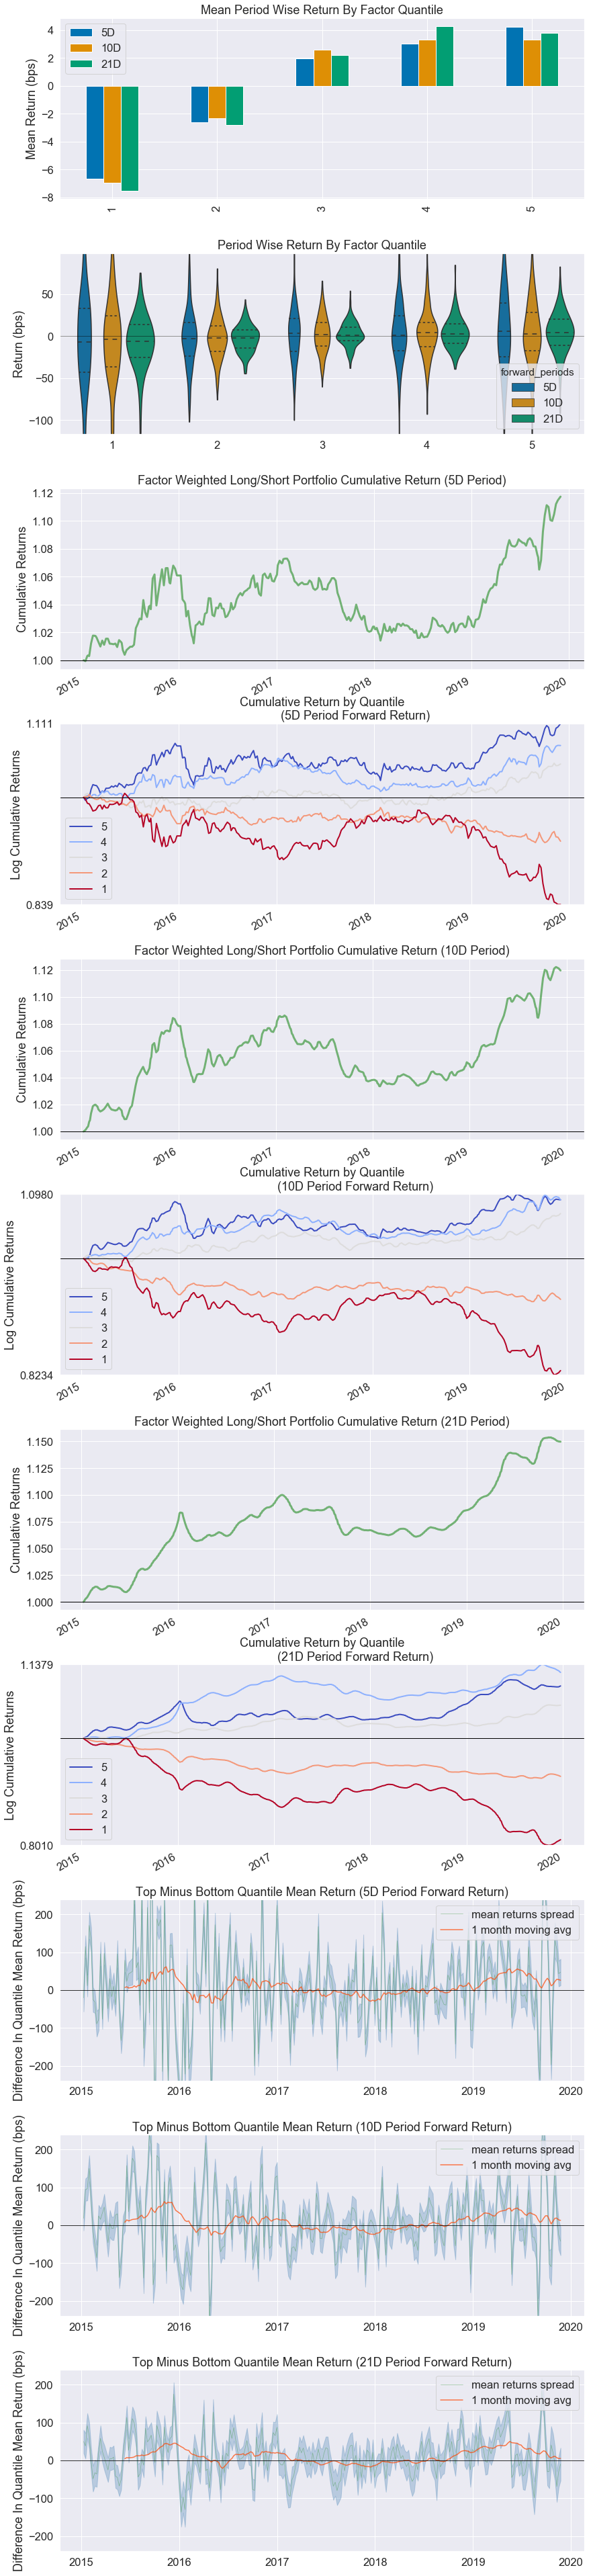

Information Analysis


,5D,10D,21D
IC Mean,0.016,0.020,0.026
IC Std.,0.084,0.086,0.080
Risk-Adjusted IC,0.192,0.236,0.331
t-stat(IC),3.020,3.704,5.206
p-value(IC),0.003,0.000,0.000
IC Skew,0.004,0.215,0.213
IC Kurtosis,0.180,0.004,0.271


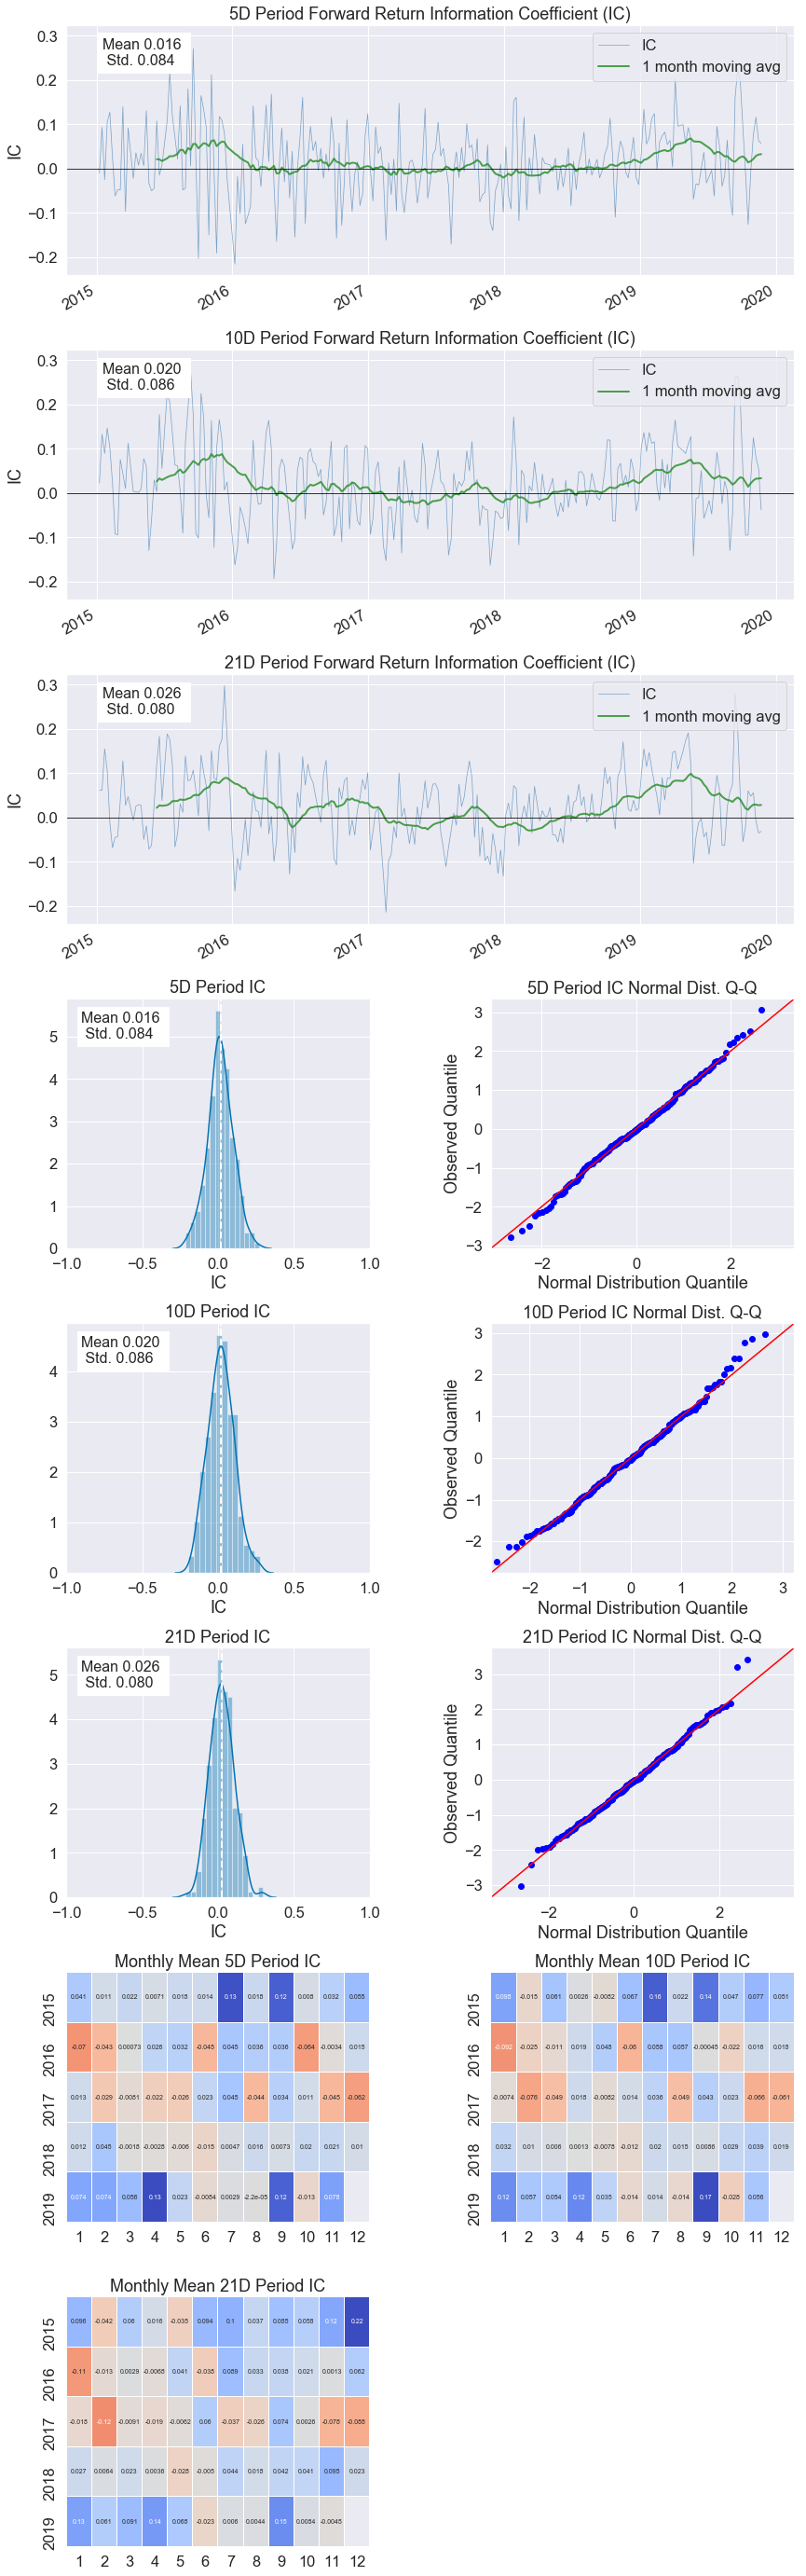

Turnover Analysis


,10D,21D,5D
Quantile 1 Mean Turnover,0.323,NaN,0.270
Quantile 2 Mean Turnover,0.575,NaN,0.511
Quantile 3 Mean Turnover,0.624,NaN,0.562
Quantile 4 Mean Turnover,0.588,NaN,0.524
Quantile 5 Mean Turnover,0.355,NaN,0.289


,5D,10D,21D
Mean Factor Rank Autocorrelation,0.829,0.76,NaN


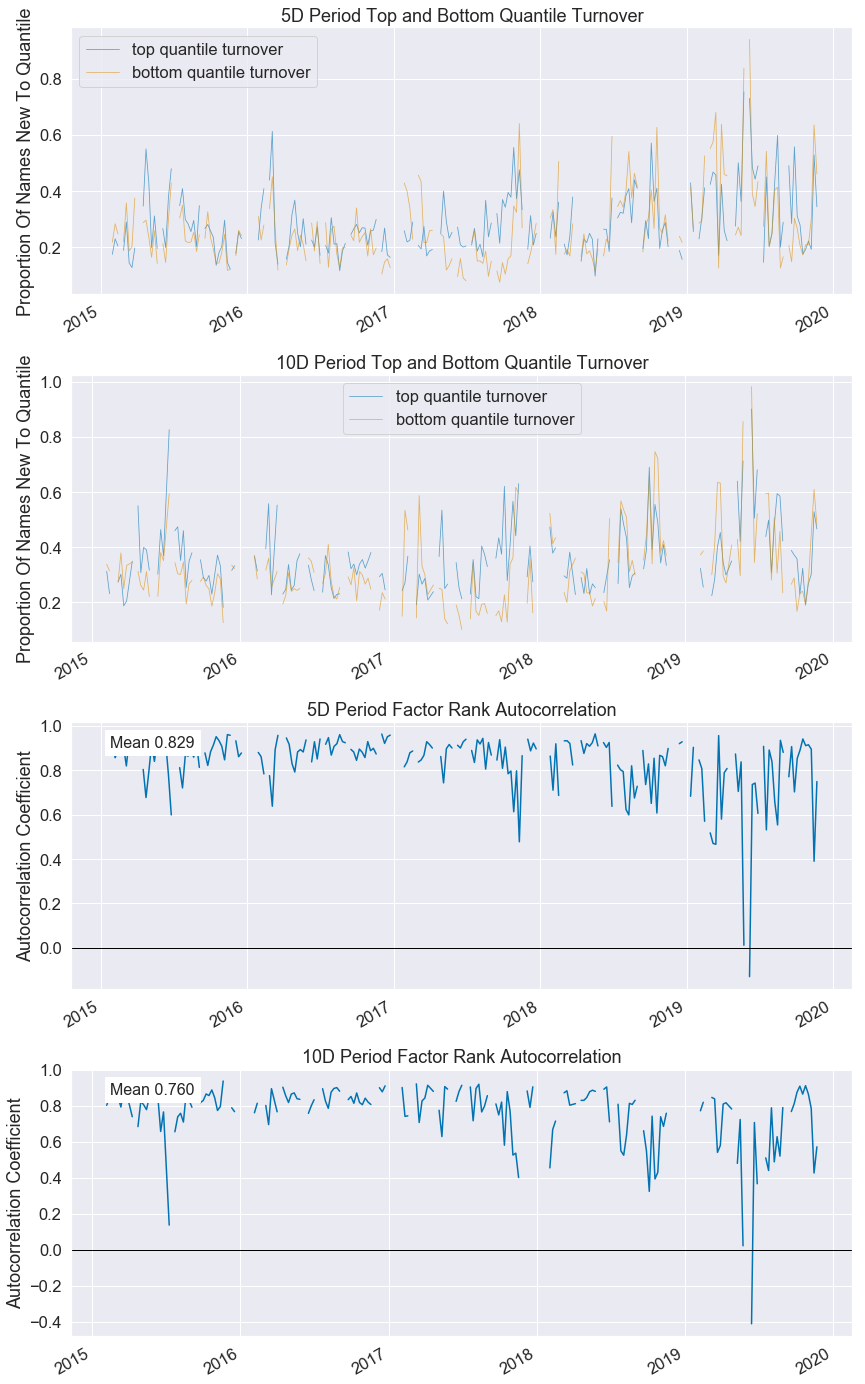

In [13]:
create_full_tear_sheet(factor_data)